<a href="https://colab.research.google.com/github/sxfchen/kmer/blob/main/kmer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import datasets and install dependencies



In [ ]:
!wget https://zenodo.org/records/7186054/files/datasets.zip

--2024-12-21 15:09:50--  https://zenodo.org/records/7186054/files/datasets.zip
Resolving zenodo.org (zenodo.org)... 188.185.43.25, 188.185.45.92, 188.185.48.194, ...
Connecting to zenodo.org (zenodo.org)|188.185.43.25|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4773839781 (4.4G) [application/octet-stream]
Saving to: ‘datasets.zip’

datasets.zip        100%[===================>]   4.45G  18.5MB/s    in 4m 17s  

2024-12-21 15:14:08 (17.7 MB/s) - ‘datasets.zip’ saved [4773839781/4773839781]



In [ ]:
# Unzip the datasets and store in data/
!unzip 'datasets.zip'

Archive:  datasets.zip
   creating: synthetic/
  inflating: synthetic/synthetic_data.h5  
  inflating: synthetic/synthetic_code_dataset.h5  
   creating: synthetic/kmer_prior/
  inflating: synthetic/kmer_prior/kmer_prior.h5  
 extracting: synthetic/kmer_prior/kmer_prior.h5.lock  
   creating: atac/
   creating: atac/.ipynb_checkpoints/
   creating: atac/saliency_subset/
   creating: atac/saliency_subset/GM12878/
   creating: atac/saliency_subset/GM12878/binary/
   creating: atac/saliency_subset/GM12878/binary/relu/
  inflating: atac/saliency_subset/GM12878/binary/relu/binary_basset_relu.pickle  
  inflating: atac/saliency_subset/GM12878/binary/relu/binary_residual_relu.pickle  
 extracting: atac/saliency_subset/GM12878/binary/relu/binary_basenji_relu.pickle.lock  
  inflating: atac/saliency_subset/GM12878/binary/relu/binary_cnn_relu.pickle  
 extracting: atac/saliency_subset/GM12878/binary/relu/binary_residual_relu.pickle.lock  
 extracting: atac/saliency_subset/GM12878/binary/relu/bin

In [ ]:
# Install dependencies
_=!python -m pip install --no-cache-dir https://github.com/p-koo/tfomics/tarball/master
_=!pip install logomaker
_=!pip install multiprocess
_=!pip install sh

In [ ]:
# Import all necessary libraries
import glob, h5py, os, re, sys, time
import itertools
from itertools import product
from pathlib import Path
from filelock import FileLock

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cupy as cp
from multiprocess import Pool
from tqdm.notebook import tqdm
from scipy import stats
from scipy.special import softmax, kl_div, rel_entr
from scipy.stats import pearsonr, spearmanr
from six.moves import cPickle
import logomaker
import sh
import tfomics
from collections import deque
from typing import Tuple
from numba import jit
import multiprocessing as mp
from scipy.sparse import csr_matrix

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, KFold
from sklearn.utils import shuffle
from sklearn.metrics import r2_score, mean_squared_error
import random
import seaborn as sns

# Functions

Find the function i made back in the ref notebook for the scatter plot

In [ ]:
##############################################################################
# PLOTTING FUNCTIONS
##############################################################################

def matrix_to_df(x, w, alphabet='ACGT'):
    """generate pandas dataframe for saliency plot
     based on grad x inputs """

    L, A = w.shape
    counts_df = pd.DataFrame(data=0.0, columns=list(alphabet), index=list(range(L)))
    for a in range(A):
        for l in range(L):
            counts_df.iloc[l,a] = w[l,a]
    return counts_df

def plot_kmer_distribution(kmerizer, weighted_kmer_frequency, prior, k, include_prior=False, figsize=(10, 5)):
    # all possible k-mers for k
    all_kmers = kmerizer.get_all_kmers(k)

    plt.figure(figsize=figsize)

    x = range(len(all_kmers))

    # weighted freq
    plt.bar(x, weighted_kmer_frequency, alpha=0.7, label='Weighted Frequency')

    if include_prior:
        plt.bar(x, prior, alpha=0.5, label='Uninformative Prior')

    remove_ends = list(weighted_kmer_frequency)
    remove_ends[0] = 0
    remove_ends[-1] = 0

    # new max
    max_val = max(remove_ends)

    y_limit = max_val / 0.9

    plt.xlabel(f'{k}-mer')
    plt.ylabel('Frequency')
    plt.ylim(bottom=0, top=y_limit)
    plt.title(f'Distribution of {k}-mer Weighted Frequencies')

    plt.legend(loc='upper right')
    plt.tight_layout()

    return plt


def plot_attribution_map(saliency_df, ax=None, title=None, figsize=(20,1), fontsize=16):
    """plot an attribution map using logomaker"""

    logomaker.Logo(saliency_df, figsize=figsize, ax=ax)
    if ax is None:
        ax = plt.gca()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.tick_params(axis="x", labelsize=fontsize)
    ax.tick_params(axis="y", labelsize=fontsize)
    ax.set_xticks([])

    if(title):
        ax.set_title(title)

    return

# maps for atac
def plot_saliency_maps(index, window, start, end, X, attr_maps, y_labels):

    print(end - start)

    plot_range = range(start, end)

    # Extract saliency scores
    x = np.expand_dims(X[index], axis=0)

    # Compute corrected saliency scores
    sal_scores_correct = [
        np.expand_dims(attr_map[index], axis=0) - np.mean(np.expand_dims(attr_map[index], axis=0), axis=2, keepdims=True)
        for attr_map in attr_maps
    ]

    saliency_dfs = [
        tfomics.impress.matrix_to_df(x, scores[0, plot_range, :])
        for scores in sal_scores_correct
    ]

    # Plotting
    fig, axes = plt.subplots(len(attr_maps), 1, figsize=(8, 3), sharex=True)

    if len(attr_maps) == 1:
        axes = [axes]

    for ax, saliency_df, label in zip(axes, saliency_dfs, y_labels):
        plot_attribution_map(saliency_df, ax, figsize=(20, 1), fontsize=14)
        ax.set_ylabel(label, fontsize=14)

    axes[-1].set_xlabel('Positions', fontsize=14)
    plt.tight_layout()
    plt.show()

# across the values for k and by regularization - prior to k weighting
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2']
methods = ['adversarial', 'manifold-gn', 'manifold-mixup', 'mixup', 'standard', 'gn', 'sn']
color_map = dict(zip(methods, colors))

def extract_info(model_name):
    parts = model_name.split('_')
    activation = 'exponential' if 'exponential' in model_name else 'relu'
    regularization = next((part for part in reversed(parts) if part in methods), 'unknown')
    return activation, regularization

def plot_avg_entropy(all_data, titles, use_regularization=False):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

    if use_regularization:
        all_data['activation'], all_data['regularization'] = zip(*all_data['model_name'].apply(extract_info))
    else:
        all_data['activation'] = all_data['model_name'].apply(lambda x: 'exp' if 'exp' in x else 'relu')

    for ax, (activation, activation_data) in zip([ax1, ax2], all_data.groupby('activation')):
        if use_regularization:
            for method in methods:
                subset = activation_data[activation_data['regularization'] == method]
                if not subset.empty:
                    avg_entropy = subset.groupby('kmer_length')['entropy'].mean()
                    ax.plot(avg_entropy.index, avg_entropy.values, marker='o', linestyle='-',
                            color=color_map.get(method, 'black'), label=method)
                else:
                    print(f"  No data for {method}")
            ax.legend(title='Regularization Method', loc='upper left')
        else:
            avg_entropy = activation_data.groupby('kmer_length')['entropy'].mean()
            ax.plot(avg_entropy.index, avg_entropy.values, marker='o', linestyle='-', color='#1f77b4')

        ax.set_xlabel('kmer_length')
        ax.set_ylabel('Average Entropy')
        ax.set_title(f'Average Entropy vs. kmer_length ({activation.capitalize()})')
        ax.grid(True)

    plt.tight_layout()
    plt.show()

# plot_avg_entropy(atac_data, ['3', '4', '5', '6', '7', '8'],use_regularization=False)

In [ ]:
##############################################################################
# DATASET LOADING
##############################################################################

def load_data(
        attr_map_path: str,
        cell_line_dir: str,
        gradient_correct: bool = True,
        normalize: bool = True
    ) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """Load dataset and attribution map (values already computed)"""

    # load attribution map
    with FileLock(os.path.expanduser(f"{attr_map_path}.lock")):
        with open(attr_map_path, "rb") as input_file:
            attr_map = cPickle.load(input_file)[:]

    # normalize attribution map & apply gradient correction
    if gradient_correct:
        attr_map = attr_map - attr_map.mean(-1, keepdims=True)
    if normalize:
        epsilon = 1e-10 # div by 0
        attr_map = attr_map / (np.sqrt(np.sum(np.sum(np.square(attr_map), axis=-1, keepdims=True), axis=-2, keepdims=True)) + epsilon)

    # load test set
    with FileLock(os.path.expanduser(f"{cell_line_dir}.lock")):
        with h5py.File(cell_line_dir, 'r') as hf:
            X = hf["X"][:]
            y = hf["y"][:]

    return attr_map, X, y


def get_model_info(saliency_dir: str, cell_line_dict: dict):
    """Create dataframe containing info of models and cell lines (like metadata)"""

    data_paths = glob.glob(f"{saliency_dir}/*/*/*/*.pickle")

    data = {
        "model": [],
        "cell_line": [],
        "cell_line_dir": [],
        "attr_map_path": [],
        "task_type": [],
        "activation": [],
    }

    for data_path in data_paths:

        attr_map_path = data_path
        model = data_path.split("/")[-1].split(".pickle")[0]
        activation = data_path.split("/")[-2]
        task_type = data_path.split("/")[-3]
        cell_line = data_path.split("/")[-4]
        cell_line_dir = cell_line_dict[cell_line]

        data["model"] += [model]
        data["cell_line"] += [cell_line]
        data["cell_line_dir"] += [cell_line_dir]
        data["attr_map_path"] += [attr_map_path]
        data["task_type"] += [task_type]
        data["activation"] += [activation]

    df = pd.DataFrame(data)

    return df


def generate_args(df, out_dir, kmer_lengths, cell_subset):
    args = []
    for _, row in df.iterrows():
        if row['cell_line'] not in cell_subset:
            continue

        out_path = f"{out_dir}/{row['cell_line']}/{row['task_type']}/{row['activation']}/{row['model']}"
        Path(out_path).mkdir(parents=True, exist_ok=True)

        for kmer_length in kmer_lengths:
            args.append((
                row['cell_line_dir'], row['cell_line'], row['model'],
                row['attr_map_path'], row['task_type'], row['activation'],
                out_path, kmer_length
            ))
    return args

In [ ]:
#############################################
# Kmerizer for getting features and plotting
############################################

class KmerizerFast:
    def __init__(self, k_list):
        self.k_list = k_list
        self.kmerizers = {k: self._create_kmerizer(k) for k in k_list}

    def _create_kmerizer(self, k):
        return {
            'n': 4**k,
            'base4_multiplier': cp.array(4**cp.arange(k-1, -1, -1)),
            'all_kmers': [''.join(p) for p in product('ACGT', repeat=k)]
        }

    def compute_kmer_features(self, X, k):
        N, L, _ = X.shape
        kmer_indices = cp.zeros((N, L-k+1), dtype=cp.int64)
        for i in range(k):
            kmer_indices += X[:, i:L-k+1+i, :].argmax(axis=2) * (4 ** (k-i-1))
        return kmer_indices

    def compute_attr_features(self, attr_scores, kmer_indices, k):
        N, L = attr_scores.shape
        n = self.kmerizers[k]['n']
        attr_features = cp.zeros((N, n), dtype=cp.float32)
        for i in range(L-k+1):
            cp.add.at(attr_features, (cp.arange(N), kmer_indices[:, i]),
                      attr_scores[:, i:i+k].mean(axis=1))
        return attr_features

    def process_sequences(self, X, attr_map, k):
        X_gpu = cp.asarray(X)
        attr_map_gpu = cp.asarray(attr_map)

        attr_scores = cp.sum(X_gpu * attr_map_gpu, axis=2)

        kmer_indices = self.compute_kmer_features(X_gpu, k)

        attr_features = self.compute_attr_features(attr_scores, kmer_indices, k)

        return attr_features

    @property
    def k(self):
        return max(self.k_list)

    def get_all_kmers(self, k):
        return self.kmerizers[k]['all_kmers']

In [ ]:
############################
# length scaling / weights
############################

def scaling(df_train):
    kmer_lengths = sorted(df_train['kmer_length'].unique())

    # how much variance is explanined by k
    var_ratios = {}
    for k in kmer_lengths:
        k_data = df_train[df_train['kmer_length'] == k]
        var_ratios[k] = np.var(k_data['entropy']) / np.var(k_data['snr'])

    # Compute length scaling based on variance ratio
    weights = {k: var_ratios[k] for k in kmer_lengths}

    total_weight = sum(weights.values())
    weights = {k: w / total_weight for k, w in weights.items()}

    return weights


def apply_weighted_kld(df, weights):
    weighted_klds = {}

    for model in df['model_name'].unique():
        model_data = df[df['model_name'] == model]
        weighted_sum = 0
        weight_sum = 0

        # create weighted sum for each model / trial
        for _, row in model_data.iterrows():
            k = row['kmer_length']
            kld = row['entropy']
            weighted_sum += kld * weights[k]
            weight_sum += weights[k]

        weighted_klds[model] = weighted_sum / weight_sum

    return weighted_klds

def split_subsets(unique_models, num_subsets=10, random_state=None):
    random.seed(random_state)
    models_to_shuffle = unique_models.copy()
    random.shuffle(models_to_shuffle)
    subset_size = len(models_to_shuffle) // num_subsets
    remainder = len(models_to_shuffle) % num_subsets
    subsets = []
    start = 0
    for i in range(num_subsets):
        end = start + subset_size + (1 if i < remainder else 0)
        subsets.append(models_to_shuffle[start:end])
        start = end
    return subsets

def evaluate_subset(subset_data, test_models):

    train_data = subset_data[~subset_data['model_name'].isin(test_models)]
    test_data = subset_data[subset_data['model_name'].isin(test_models)]

    # Calculate weights - train data is most of the subsets
    weights = scaling(train_data)

    # Get weighted KLDs for all data
    train_weighted_klds = apply_weighted_kld(train_data, weights)
    test_weighted_klds = apply_weighted_kld(test_data, weights)

    train_models = train_data['model_name'].unique()
    test_models = test_data['model_name'].unique()

    X = np.array([train_weighted_klds[m] for m in train_models]).reshape(-1, 1)
    y = train_data.groupby('model_name')['log_snr'].first().loc[train_models].values
    X_test = np.array([test_weighted_klds[m] for m in test_models]).reshape(-1, 1)
    y_test = test_data.groupby('model_name')['log_snr'].first().loc[test_models].values

    # 5 fold cv
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    cv_scores = []

    for train_idx, val_idx in kf.split(X):
        X_cv_train, X_cv_val = X[train_idx], X[val_idx]
        y_cv_train, y_cv_val = y[train_idx], y[val_idx]

        reg = LinearRegression()
        reg.fit(X_cv_train, y_cv_train)
        cv_scores.append(reg.score(X_cv_val, y_cv_val))

    # Final model fitting on all training data for test set evaluation
    final_reg = LinearRegression()
    final_reg.fit(X, y)
    test_r2 = final_reg.score(X_test, y_test)

    return np.mean(cv_scores), np.std(cv_scores), test_r2, weights

In [ ]:
def matrix_to_seq_list(
        seq_block,
        dna_dict={
            0: "A",
            1: "C",
            2: "G",
            3: "T"
        }
    ):
    seq_list = []
    for seq in seq_block:
        seq_str = []
        for one_hot in seq:
            # Find the index of the 1 in the one-hot vector
            index = np.argmax(one_hot)
            # Map the index to the corresponding nucleotide
            seq_str.append(dna_dict[index])

        seq_list.append("".join(seq_str))
    return seq_list

def matrix_to_seq(
        seq_block,
        dna_dict = {
            0: "A",
            1: "C",
            2: "G",
            3: "T"
          }
     ):

    return "".join([dna_dict[np.where(i)[0][0]] for i in seq_block])

In [ ]:
##############################################################################
# SYNTHETIC DATASET FUNCTIONS
##############################################################################

def get_dataset(filepath):

    with h5py.File(filepath, 'r') as dataset:
        x_train = np.array(dataset['X_train']).astype(np.float32)
        y_train = np.array(dataset['Y_train']).astype(np.float32)
        x_valid = np.array(dataset['X_valid']).astype(np.float32)
        y_valid = np.array(dataset['Y_valid']).astype(np.int32)
        x_test = np.array(dataset['X_test']).astype(np.float32)
        y_test = np.array(dataset['Y_test']).astype(np.int32)
        model_test = np.array(dataset['model_test']).astype(np.float32)

    model_test = model_test.transpose([0,2,1])
    x_train = x_train.transpose([0,2,1])
    x_valid = x_valid.transpose([0,2,1])
    x_test = x_test.transpose([0,2,1])

    N, L, A = x_train.shape

    # get positive samples
    pos_index = np.where(y_test[:,0])[0]
    X = x_test[pos_index]
    X_model = model_test[pos_index]

    return (x_train, y_train), (x_valid, y_valid), (x_test, y_test), X, X_model


def allkeys(obj):
    "Recursively find all keys in an h5py.Group."
    keys = (obj.name,)
    if isinstance(obj, h5py.Group):
        for key, value in obj.items():
            if isinstance(value, h5py.Group):
                keys = keys + allkeys(value)
            else:
                keys = keys + (value.name,)
    return keys

# Analysis

In [ ]:
# data paths
BASE_DIR = Path.cwd()
evaluation_path = BASE_DIR.joinpath("atac/atac_model_pearson.csv")

DATA_DIR = BASE_DIR.joinpath("atac/cell_line_testsets")
saliency_dir = BASE_DIR.joinpath("atac/saliency_subset")

# cell line paths
cell_line_dict = {
    "A549": f"{DATA_DIR}/cell_line_8.h5",
    "HCT116": f"{DATA_DIR}/cell_line_9.h5",
    "GM12878": f"{DATA_DIR}/cell_line_7.h5",
    "K562": f"{DATA_DIR}/cell_line_5.h5",
    "PC-3": f"{DATA_DIR}/cell_line_13.h5",
    "HepG2": f"{DATA_DIR}/cell_line_2.h5"
}

print(BASE_DIR, evaluation_path, DATA_DIR, saliency_dir)
eval_df = pd.read_csv(evaluation_path)

/content /content/atac/atac_model_pearson.csv /content/atac/cell_line_testsets /content/atac/saliency_subset


In [ ]:
# get args for atac data
out_dir = BASE_DIR.joinpath("results/atac/method_1")
df = get_model_info(saliency_dir=saliency_dir, cell_line_dict=cell_line_dict)

kmer_lengths = [3, 4, 5, 6, 7, 8]
cell_subset = ['GM12878']

atac_args = {}

for kmer_length in kmer_lengths:
    my_args = generate_args(df, out_dir, [kmer_length], cell_subset)
    atac_args[f'atac_args_{kmer_length}'] = my_args

In [ ]:
# get args for synthetic data
synthetic_out_dir = BASE_DIR.joinpath(f"results/synthetic/method_1")
synthetic_code_path = BASE_DIR.joinpath(f"synthetic/synthetic_code_dataset.h5")
synthetic_path = BASE_DIR.joinpath(f"synthetic/synthetic_data.h5")

synthetic_args = {}

with h5py.File(synthetic_path, 'r') as f:
    for grp_name in f.keys():
        attr_map = f[grp_name]["attr_map"][:]
        auroc = f[grp_name]["auroc"][()]
        snr = f[grp_name]["snr"][()]
        path = f[grp_name]["path"][()].decode('UTF-8')

        lr_type, bn, activation, method, attr_type, trial = path.split('/')[1:]
        trial = int(trial)

        for kmer_length in kmer_lengths:
            out_path = f"{synthetic_out_dir}/{kmer_length}{path}"
            Path(f"{out_path}").mkdir(parents=True, exist_ok=True)

            if f'synthetic_args_{kmer_length}' not in synthetic_args:
                synthetic_args[f'synthetic_args_{kmer_length}'] = []

            synthetic_args[f'synthetic_args_{kmer_length}'].append(
                (lr_type, bn, activation, method, attr_type, trial, out_path, path, attr_map, auroc, snr, kmer_length)
            )

In [ ]:
# load both priors (length from 3 to 8)
atac_kmer_path = BASE_DIR.joinpath(f"atac/kmer_prior/GM12878")
kmer_path = BASE_DIR.joinpath(f"synthetic/kmer_prior")

def read_kmer_prior(full_path, kmer_length):
    file_path = f"{full_path}/kmer_prior.h5"
    lock_path = f"{file_path}.lock"

    with FileLock(os.path.expanduser(lock_path)):
        with h5py.File(file_path, "r") as f:
            kmer_prior = f[f"{kmer_length}"][:]

    return kmer_prior

atac_priors = {}
synthetic_priors = {}

for kmer_length in kmer_lengths:
    atac_priors[f'atac_prior_{kmer_length}'] = read_kmer_prior(atac_kmer_path, kmer_length)
    synthetic_priors[f'synthetic_prior_{kmer_length}'] = read_kmer_prior(kmer_path, kmer_length)

In [ ]:
def process_model(args, kmer_prior, kmerizer, kmer_length, is_synthetic=False):
    if is_synthetic:
        lr_type, bn, activation, method, attr_type, trial, out_path, path, attr_map, auroc, snr = args[:11]
        model_name = f"{lr_type}_{bn}_{activation}_{method}_{attr_type}_{trial}"
        _, _, _, X, _ = get_dataset(synthetic_code_path)
    else:
        cell_line_dir, cell_line, model, attr_map_path, task_type, activation, out_path = args[:7]
        model_name = model
        try:
            attr_map, X, _ = load_data(attr_map_path, cell_line_dir)
        except Exception as e:
            print(f"Error loading data for model: {model_name}")
            return model_name, np.nan, None, None if is_synthetic else None

    try:
        attr_features = kmerizer.process_sequences(X, attr_map, kmer_length)

        # Calculate absolute attribution and sum
        abs_attr = cp.abs(attr_features)
        sum_abs_attr_safe = cp.sum(abs_attr, axis=0) + 1e-10

        # Compute weights and weighted k-mers
        weights = sum_abs_attr_safe / cp.sum(sum_abs_attr_safe)
        weighted = cp.array(kmer_prior) * weights

        # Normalize the weighted k-mers
        sum_weighted = cp.sum(weighted)
        weight_kmer = weighted / (sum_weighted if sum_weighted != 0 else 1)

        # Compute entropy
        entropy = float(cp.sum(kl_div(weight_kmer.get(), kmer_prior)))

        if is_synthetic==False:
            pr_corr = eval_df[eval_df["new_model_name"] == model][cell_line].to_numpy()[0]

        if np.isnan(entropy) or np.isinf(entropy):
            raise ValueError(f"Invalid entropy value: {entropy}")

        return model_name, entropy, weight_kmer.get(), snr if is_synthetic else pr_corr, None if is_synthetic else task_type, None if is_synthetic else activation
    except Exception as e:
        print(f"Error processing model: {model_name}: {str(e)}")
        return model_name, np.nan, None, None if is_synthetic else None


def compute_entropy_for_models(args_dict, prior_dict, kmer_lengths, is_synthetic=False):
    results_dict = {}
    weighted_kmers_dict = {}

    kmerizer = KmerizerFast(kmer_lengths)

    for kmer_length in kmer_lengths:
        args_key = f"{'synthetic' if is_synthetic else 'atac'}_args_{kmer_length}"
        prior_key = f"{'synthetic' if is_synthetic else 'atac'}_prior_{kmer_length}"

        args_list = args_dict[args_key]
        kmer_prior = prior_dict[prior_key]

        results_list = []
        weighted_kmers = {}

        for args in args_list:
            model, entropy, weight_kmer, additional, task, activation = process_model(args, kmer_prior, kmerizer, kmer_length, is_synthetic=is_synthetic)

            result = {
                'model_name': model,
                'entropy': entropy,
                'kmer_length': kmer_length,
            }
            if is_synthetic:
                result['snr'] = additional
            else:
                result['pr_corr'] = additional
                result['task_type'] = task
                result['activation'] = activation
            results_list.append(result)

            if weight_kmer is not None:
                weighted_kmers[model] = weight_kmer

        results_dict[kmer_length] = pd.DataFrame(results_list)
        weighted_kmers_dict[kmer_length] = weighted_kmers

    return results_dict, weighted_kmers_dict

In [ ]:
atac_dfs, atac_weighted_kmers = compute_entropy_for_models(atac_args, atac_priors, kmer_lengths, is_synthetic=False)

In [ ]:
synthetic_dfs, synthetic_weighted_kmers = compute_entropy_for_models(synthetic_args, synthetic_priors, kmer_lengths, is_synthetic=True)

In [ ]:
all_atac = []

for i in range(3, 9):
    globals()[f'atac_df_{i}'] = atac_dfs[i]
    all_atac.append(atac_dfs[i])

    globals()[f'atac_weighted_kmers_{i}'] = atac_weighted_kmers[i]
    globals()[f'atac_prior_{i}'] = atac_priors[f'atac_prior_{i}']

atac = pd.concat(all_atac, ignore_index=True)

In [ ]:
all_synthetic = []

for i in range(3, 9):
    globals()[f'synthetic_df_{i}'] = synthetic_dfs[i]
    all_synthetic.append(synthetic_dfs[i])

    globals()[f'synthetic_weighted_kmers_{i}'] = synthetic_weighted_kmers[i]
    globals()[f'synthetic_prior_{i}'] = synthetic_priors[f'synthetic_prior_{i}']

synthetic = pd.concat(all_synthetic, ignore_index=True)
synthetic['log_snr'] = np.log(synthetic['snr'])

# Figures

## Weighted kmer distribution vs prior

In [ ]:
# Using 6mers for plotting right now - but can do with any k, just not all at once
kmerizer = KmerizerFast([3, 4, 5, 6, 7, 8])

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

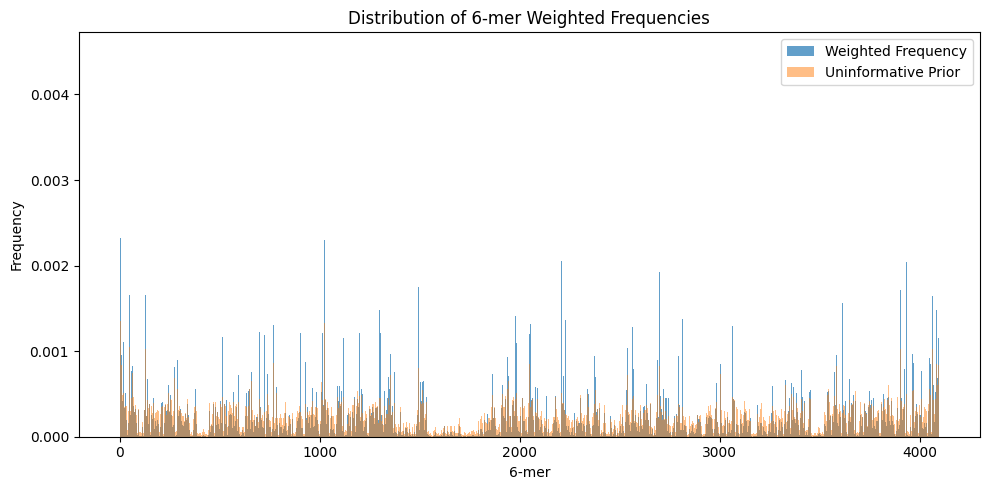

In [ ]:
plot_kmer_distribution(kmerizer, atac_weighted_kmers_6['cnn_base_all_exp'],atac_prior_6,6,include_prior=True)
# excluding artifacts

In [ ]:
print(atac_prior_6)

[0.00297607 0.00064164 0.0008517  ... 0.00084165 0.00082226 0.00291747]


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

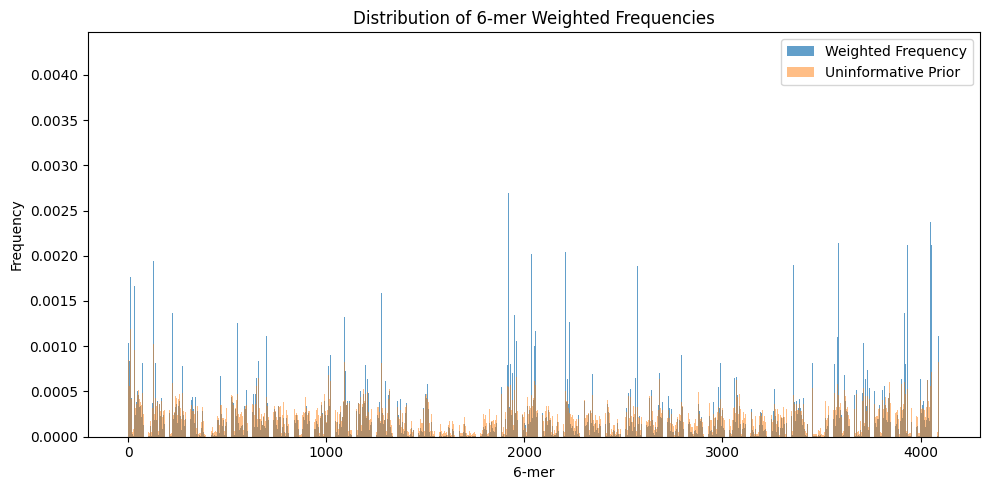

In [ ]:
plot_kmer_distribution(kmerizer, atac_weighted_kmers_6['cnn_base_task_relu'], atac_prior_6, 6,include_prior=True)

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

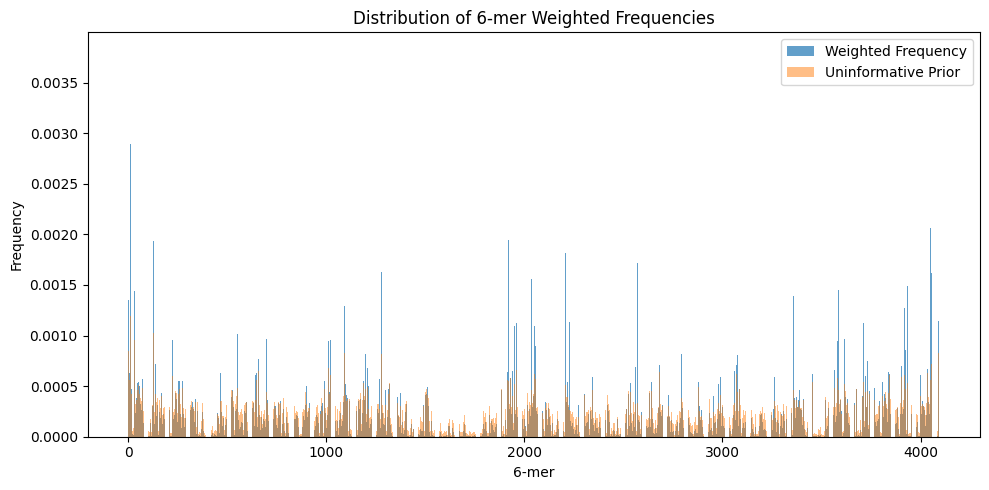

In [ ]:
plot_kmer_distribution(kmerizer, atac_weighted_kmers_6['binary_residual_relu'], atac_prior_6, 6, include_prior=True)

## KLD for different kmer lengths

In [ ]:
def main(data):
    unique_models = data['model_name'].unique().tolist()
    model_subsets = split_subsets(unique_models, num_subsets=10, random_state=42)

    results = []
    weights_results = []

    for i, test_models in enumerate(model_subsets):
        cv_r2_mean, cv_r2_std, test_r2, weights = evaluate_subset(data, test_models)

        result = {
            'Subset': i+1,
            'Test_Models': ', '.join(test_models),
            'CV_R2_Mean': cv_r2_mean,
            'CV_R2_Std': cv_r2_std,
            'Test_R2': test_r2
        }
        results.append(result)

        # get weights
        weights_result = {'Subset': i+1}
        for k, w in weights.items():
            weights_result[f'kmer_{k}_weight'] = w
        weights_results.append(weights_result)

    return pd.DataFrame(results), pd.DataFrame(weights_results)

results_df, weights_df = main(synthetic)

In [ ]:
mean_r2 = results_df['Test_R2'].mean()
std_r2 = results_df['Test_R2'].std()

print(f"R^2: {mean_r2:.3f} ± {std_r2:.3f}")

R^2: 0.805 ± 0.050


In [ ]:
# Calculate average weights for each kmer length from weights_df
avg_weights = {}
for k in range(3, 9):
    avg_weights[k] = weights_df[f'kmer_{k}_weight'].mean()

print("Average weights for each kmer length:")
for k, w in avg_weights.items():
    print(f"k={k}: {w:.4f}")

Average weights for each kmer length:
k=3: 0.0106
k=4: 0.0512
k=5: 0.1627
k=6: 0.2880
k=7: 0.2805
k=8: 0.2070


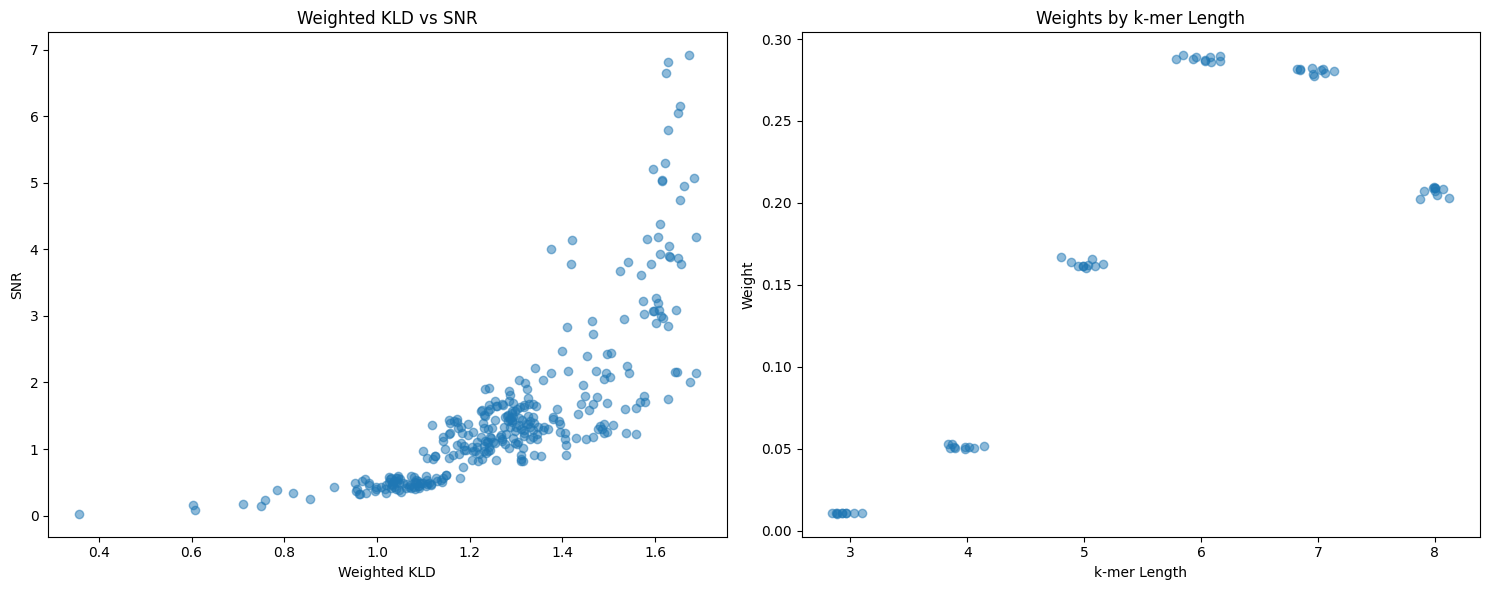

In [ ]:
def prepare_scatter_data(all_data, avg_weights):
    scatter_data = []

    unique_models = all_data['model_name'].unique()

    # for each model
    for model in unique_models:
        model_data = all_data[all_data['model_name'] == model]
        weighted_kld = 0

        # calculate weighted KLD using avg weights
        for k in range(3, 9):
            weight = avg_weights[k]
            kld = model_data[model_data['kmer_length'] == k]['entropy'].iloc[0]
            weighted_kld += weight * kld

        scatter_data.append({
            'weighted_kld': weighted_kld,
            'model': model,
            'snr':model_data['snr'].iloc[0]
        })

    return pd.DataFrame(scatter_data)


def prepare_weight_data(weights_df):
    weight_data = []

    for subset in range(1, 11):
        subset_weights = weights_df[weights_df['Subset'] == subset]
        for k in range(3, 9):
            weight_data.append({
                'kmer_length': k,
                'weight': subset_weights[f'kmer_{k}_weight'].values[0],
                'subset': subset
            })

    return pd.DataFrame(weight_data)


scatter_data = prepare_scatter_data(synthetic, avg_weights)
weight_data = prepare_weight_data(weights_df)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# scatter plot
ax1.scatter(scatter_data['weighted_kld'], scatter_data['snr'], alpha=0.5)

ax1.set_xlabel('Weighted KLD')
ax1.set_ylabel('SNR')
ax1.set_title('Weighted KLD vs SNR')

# jitter plot (weights)
x_jitter = np.random.normal(0, 0.1, size=len(weight_data))
ax2.scatter(weight_data['kmer_length'] + x_jitter, weight_data['weight'], alpha=0.5)
ax2.set_xlabel('k-mer Length')
ax2.set_ylabel('Weight')
ax2.set_title('Weights by k-mer Length')
ax2.set_xticks(range(3, 9))

plt.tight_layout()
plt.show()

In [ ]:
synthetic_entropy = pd.read_csv('synthetic_entropy.csv') # import - generated from original code

correlation1, _ = spearmanr(scatter_data['weighted_kld'], scatter_data['snr'])
correlation2, _ = spearmanr(synthetic_entropy['entropy'], synthetic_entropy['snr'])

print(f'New: {correlation1:.3f}')
print(f'Original: {correlation2:.3f}')

New: 0.868
Original: 0.587


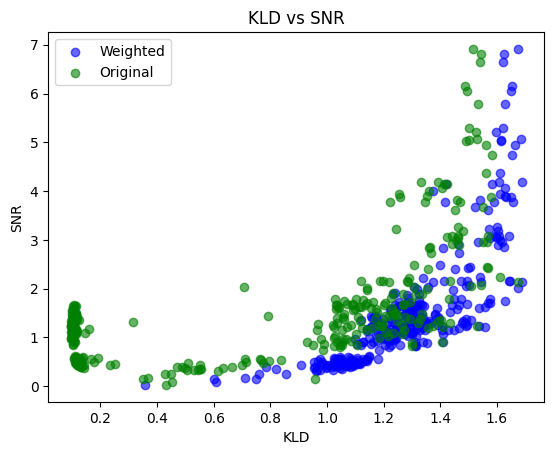

In [ ]:
plt.scatter(scatter_data['weighted_kld'], scatter_data['snr'], color='blue',alpha=0.6,label='Weighted')
plt.scatter(synthetic_entropy['entropy'], synthetic_entropy['snr'],color='green',alpha=0.6,label='Original')
plt.xlabel('KLD')
plt.ylabel('SNR')
plt.title('KLD vs SNR')
plt.legend()

In [ ]:
model_scores = {}

for model in atac['model_name'].unique():
  model_data = atac[atac['model_name'] == model]
  weighted_sum = 0

  for k in range(3, 9):
    weight = avg_weights[k]
    kld = model_data[model_data['kmer_length'] == k]['entropy'].iloc[0]
    weighted_sum += weight * kld

  model_scores[model] = weighted_sum

atac['weighted_kld'] = atac['model_name'].map(model_scores)
atac.drop_duplicates(subset='model_name', keep='first') # this is only an issue if i look at entropy from atac final

atac.head()

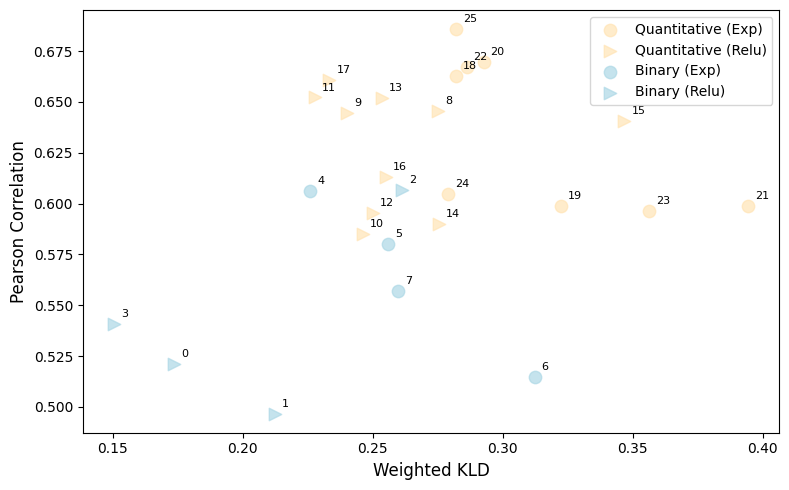

In [ ]:
def create_category(row):
    return f"{row['task_type']}_{row['activation']}"

plt.figure(figsize=(8, 5))

styles = {
    'quantitative_exp': {'color': 'moccasin', 'marker': 'o', 'label': 'Quantitative (Exp)'},
    'quantitative_relu': {'color': 'moccasin', 'marker': '>', 'label': 'Quantitative (Relu)'},
    'binary_exp': {'color': 'lightblue', 'marker': 'o', 'label': 'Binary (Exp)'},
    'binary_relu': {'color': 'lightblue', 'marker': '>', 'label': 'Binary (Relu)'}
}

# Add category column
atac['category'] = atac.apply(create_category, axis=1)

# Plot each category and add indices
for category, style in styles.items():
    mask = atac['category'] == category
    category_data = atac[mask]

    # Plot the points
    plt.scatter(category_data['weighted_kld'],
                category_data['pr_corr'],
                c=style['color'],
                marker=style['marker'],
                s=80,
                label=style['label'],
                alpha=0.7)

    # Add index labels for each point
    for idx, row in category_data.iterrows():
        plt.annotate(str(idx),
                    (row['weighted_kld'], row['pr_corr']),
                    xytext=(5, 5),
                    textcoords='offset points',
                    fontsize=8)

plt.xlabel('Weighted KLD', fontsize=12)
plt.ylabel('Pearson Correlation', fontsize=12)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# residual 32 all exp and residual 32 task relu
# cnn 32 task exp and binary residual relu
# binary basset exp, binary cnn relu

atac.head(26)

,model_name,entropy,kmer_length,pr_corr,task_type,activation,weighted_kld,category
0,binary_cnn_relu,0.039815,3,0.521219,binary,relu,0.173727,binary_relu
1,binary_basenji_relu,0.066771,3,0.496773,binary,relu,0.212548,binary_relu
2,binary_residual_relu,0.089643,3,0.606609,binary,relu,0.261376,binary_relu
3,binary_basset_relu,0.034443,3,0.540928,binary,relu,0.150743,binary_relu
4,binary_residual_exp,0.057813,3,0.606411,binary,exp,0.225914,binary_exp
5,binary_cnn_exp,0.053290,3,0.580139,binary,exp,0.255883,binary_exp
6,binary_basset_exp,0.099181,3,0.514730,binary,exp,0.312240,binary_exp
7,binary_basenji_exp,0.099748,3,0.556909,binary,exp,0.259834,binary_exp
8,residual_base_task_relu,0.059603,3,0.645654,quantitative,relu,0.275060,quantitative_relu
9,residual_32_all_relu,0.059070,3,0.644368,quantitative,relu,0.240273,quantitative_relu


## Attribution maps

In [ ]:
cell_subset = ["GM12878"]
cell_line = cell_subset[0]

model_subset = [
    'residual_32_all_exp',
    "residual_32_task_relu"
]

model_name_list = []
attr_map_list = []
cell_line_dir = cell_line_dict[cell_subset[0]]

for i, model in enumerate(model_subset):
    a = df[df["model"] == model]
    for cell_line in cell_subset:
        a = a[a["cell_line"] == cell_line]
        model_name_list += [a.model.to_numpy()[0]]
        attr_map_list += [a.attr_map_path.to_numpy()[0]]

# for the models in the subset shown above
attr_map_0, X, _ = load_data(attr_map_list[0], cell_line_dict[cell_subset[0]])
attr_map_1, X, _ = load_data(attr_map_list[1], cell_line_dict[cell_subset[0]])

attr_maps_atac = [attr_map_0, attr_map_1]
y_labels_atac = ['Saliency','Saliency']

75


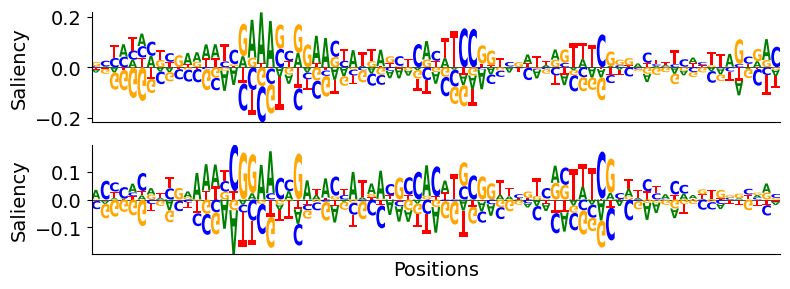

In [ ]:
plot_saliency_maps(1636, 50, 887, 962, X, attr_maps_atac, y_labels_atac)

75


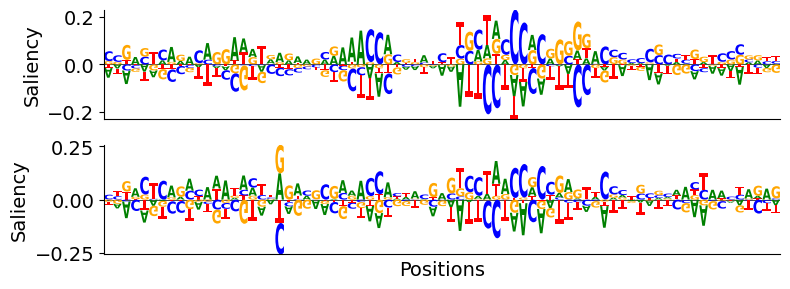

In [ ]:
plot_saliency_maps(1622, 50, 980, 1055, X, attr_maps_atac, y_labels_atac)

75


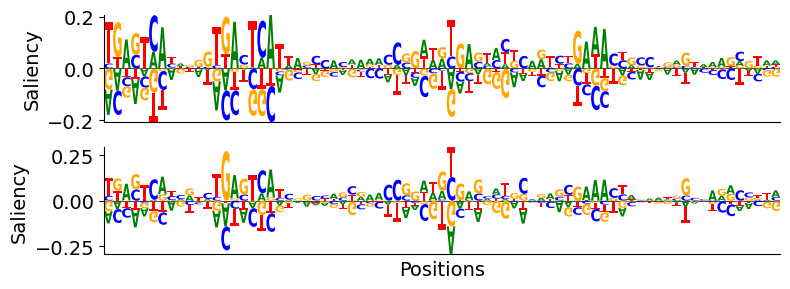

In [ ]:
plot_saliency_maps(2648, 50, 975, 1050, X, attr_maps_atac, y_labels_atac)

75


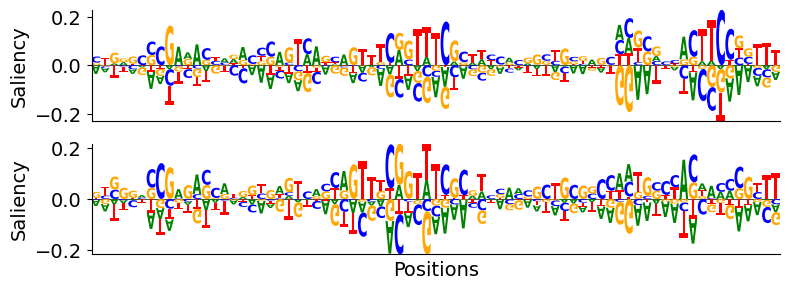

In [ ]:
plot_saliency_maps(1679, 50, 1036, 1111, X, attr_maps_atac, y_labels_atac)

75


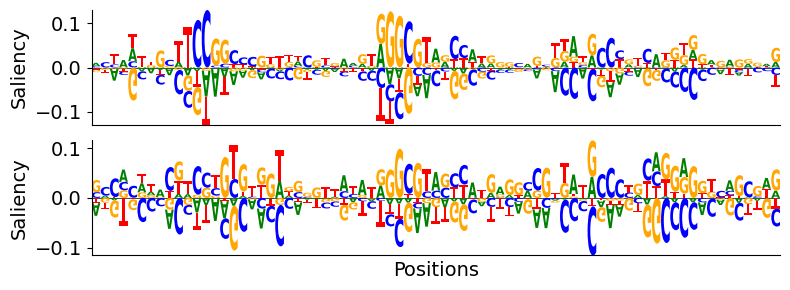

In [ ]:
plot_saliency_maps(1448, 50, 1150, 1225, X, attr_maps_atac, y_labels_atac)

75


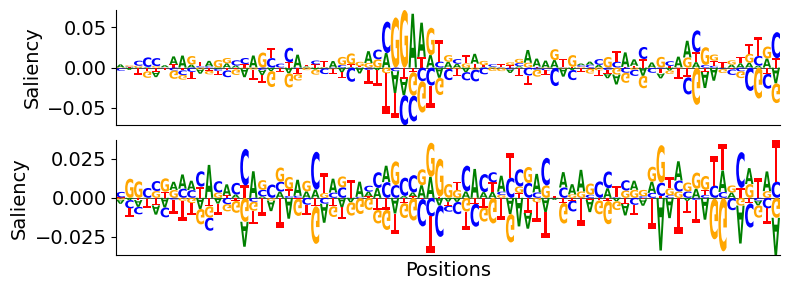

In [ ]:
plot_saliency_maps(257, 50, 624, 699, X, attr_maps_atac, y_labels_atac) #12